<a href="https://colab.research.google.com/github/Quantyca/demo-ateam-ai-misc/blob/master/recommendation/CollabMovielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

## Movielens 100k

The full Movielens 100k data dataset is available at http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
user,item,title = 'userId','movieId','title'

In [0]:
path=Config.data_path()/'Movielens100k'
path

PosixPath('/root/.fastai/data/Movielens100k')

In [0]:
mkdir -p /root/.fastai/data/Movielens100k

In [0]:
# Download the file from gs store
file = path/'ml100k.zip'
_=download_url('https://storage.googleapis.com/ml_quantyca_it/shared/Movielens100k/ml100k.zip', file, overwrite=False)
file.chmod(600)

In [0]:
cd /root/.fastai/data/Movielens100k

/root/.fastai/data/Movielens100k


In [0]:
ls

ml100k.zip*


In [0]:
import zipfile
with zipfile.ZipFile('ml100k.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [0]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
len(ratings)

100000

In [0]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [0]:
data.show_batch()

userId,title,target
94,Cemetery Man (Dellamorte Dellamore) (1994),3.0
305,Die Hard (1988),2.0
438,Star Wars (1977),5.0
10,L.A. Confidential (1997),4.0
295,Bedknobs and Broomsticks (1971),4.0


In [0]:
y_range = [0,5.5] #sigmoide, tolgo 0.5 all'inizio e aggiungo 0.5 alla fine

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1) #n_factor specifica embedding, db da 100 quindi di solito si prende la metà circa

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


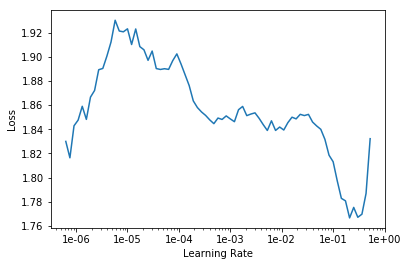

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.925654,0.952507,00:11
1,0.859030,0.881426,00:12
2,0.792925,0.834879,00:12
3,0.661680,0.811844,00:11
4,0.562594,0.810252,00:12


In [0]:
learn.save('dotprod')

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [0]:
g = rating_movie.groupby(title)['rating'].count()
g.sort_values(ascending=False)[:1000]

title
Star Wars (1977)                                       583
Contact (1997)                                         509
Fargo (1996)                                           508
Return of the Jedi (1983)                              507
Liar Liar (1997)                                       485
English Patient, The (1996)                            481
Scream (1996)                                          478
Toy Story (1995)                                       452
Air Force One (1997)                                   431
Independence Day (ID4) (1996)                          429
Raiders of the Lost Ark (1981)                         420
Godfather, The (1972)                                  413
Pulp Fiction (1994)                                    394
Twelve Monkeys (1995)                                  392
Silence of the Lambs, The (1991)                       390
Jerry Maguire (1996)                                   384
Chasing Amy (1997)                                

In [0]:
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [0]:
movie_bias = learn.bias(top_movies, is_item=True)# true se voglio item, false se voglio users
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i], g.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [0]:
lowest_bias = sorted(movie_ratings, key=item0)[:1000]
lowest_bias

[(tensor(-0.3644),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106,
  19),
 (tensor(-0.2989),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142,
  21),
 (tensor(-0.2879),
  'Mortal Kombat: Annihilation (1997)',
  1.9534883720930232,
  43),
 (tensor(-0.2585), 'Striptease (1996)', 2.2388059701492535, 67),
 (tensor(-0.2562), 'Bio-Dome (1996)', 1.903225806451613, 31),
 (tensor(-0.2504), 'Cable Guy, The (1996)', 2.339622641509434, 106),
 (tensor(-0.2475), 'Crow: City of Angels, The (1996)', 1.9487179487179487, 39),
 (tensor(-0.2463), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053, 57),
 (tensor(-0.2317), 'Barb Wire (1996)', 1.9333333333333333, 30),
 (tensor(-0.2308), "Joe's Apartment (1996)", 2.2444444444444445, 45),
 (tensor(-0.2043), 'Thinner (1996)', 2.4489795918367347, 49),
 (tensor(-0.2031), 'Grease 2 (1982)', 2.0, 24),
 (tensor(-0.2022),
  'Beautician and the Beast, The (1997)',
  2.313953488372093,
  86),
 (tensor(-0.2015), 'Beverly Hill

In [0]:
top_bias = sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:1000]
top_bias

[(tensor(0.6030), 'Shawshank Redemption, The (1994)', 4.445229681978798, 283),
 (tensor(0.5842), "Schindler's List (1993)", 4.466442953020135, 298),
 (tensor(0.5738), 'Titanic (1997)', 4.2457142857142856, 350),
 (tensor(0.5575), 'Rear Window (1954)', 4.3875598086124405, 209),
 (tensor(0.5257), 'Silence of the Lambs, The (1991)', 4.28974358974359, 390),
 (tensor(0.5126), 'L.A. Confidential (1997)', 4.161616161616162, 297),
 (tensor(0.5122), 'Star Wars (1977)', 4.3584905660377355, 583),
 (tensor(0.4933), 'Good Will Hunting (1997)', 4.262626262626263, 198),
 (tensor(0.4897), 'Vertigo (1958)', 4.251396648044692, 179),
 (tensor(0.4789), 'Boot, Das (1981)', 4.203980099502488, 201),
 (tensor(0.4783), 'Godfather, The (1972)', 4.283292978208232, 413),
 (tensor(0.4724), 'Casablanca (1942)', 4.45679012345679, 243),
 (tensor(0.4697), 'Usual Suspects, The (1995)', 4.385767790262173, 267),
 (tensor(0.4563), 'As Good As It Gets (1997)', 4.196428571428571, 112),
 (tensor(0.4510),
  "One Flew Over the 

In [0]:
list(filter(lambda a: a[2] >=3 , lowest_bias))[:10]

[(tensor(-0.0928), 'Parent Trap, The (1961)', 3.095890410958904, 73),
 (tensor(-0.0716), 'Kalifornia (1993)', 3.2203389830508473, 59),
 (tensor(-0.0663),
  'Cook the Thief His Wife & Her Lover, The (1989)',
  3.024390243902439,
  82),
 (tensor(-0.0647),
  'Bridges of Madison County, The (1995)',
  3.1641791044776117,
  67),
 (tensor(-0.0616),
  'So I Married an Axe Murderer (1993)',
  3.0526315789473686,
  95),
 (tensor(-0.0592),
  'Robin Hood: Prince of Thieves (1991)',
  3.2266666666666666,
  75),
 (tensor(-0.0571), 'Barcelona (1994)', 3.018867924528302, 53),
 (tensor(-0.0558), 'Fools Rush In (1997)', 3.0, 24),
 (tensor(-0.0530), 'River Wild, The (1994)', 3.143835616438356, 146),
 (tensor(-0.0528), 'Fox and the Hound, The (1981)', 3.1475409836065573, 61)]